In [6]:
import pandas as pd

# Chargez le fichier CSV dans un DataFrame pandas
df = pd.read_csv("dataTp2.csv")

# Affichez les premières lignes du DataFrame(Test).
df.head()


,Unnamed: 0,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,2157,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,1223,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,1083,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,456,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,1448,0.458818,0.483091,0.406909,0.297818,0.395273,0


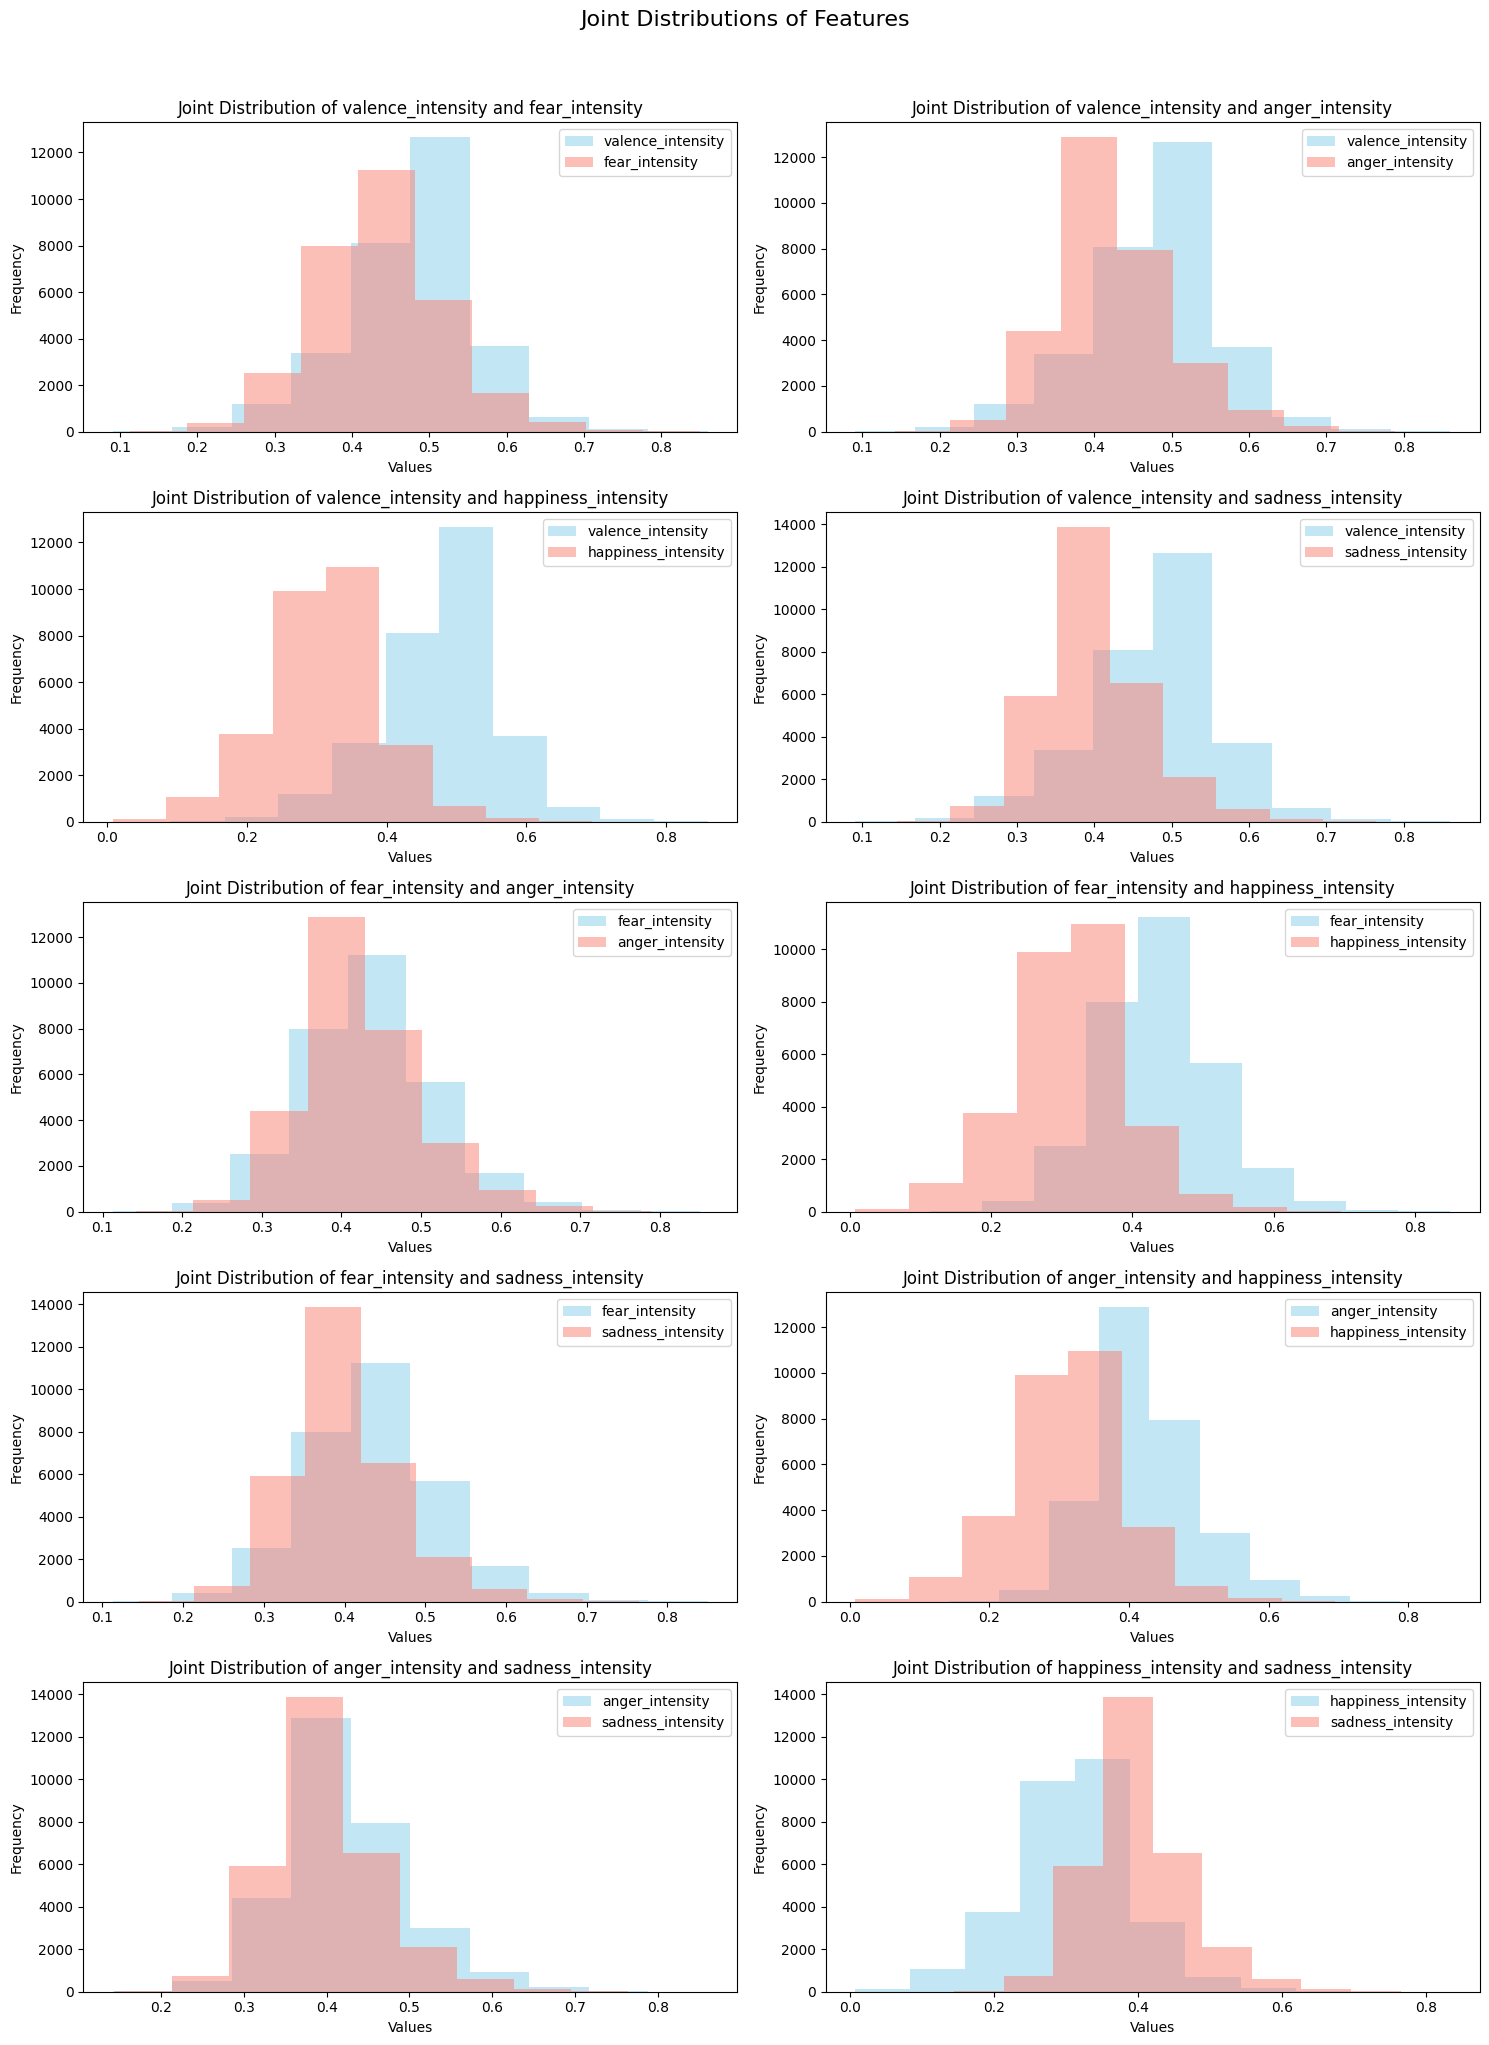

In [ ]:
import matplotlib.pyplot as plt

# Select the features for joint distribution plots
selected_features = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']

# Create all possible pairs of features
feature_pairs = [(feature1, feature2) for i, feature1 in enumerate(selected_features) for feature2 in selected_features[i+1:]]

# Create the joint distribution histogram plots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Joint Distributions of Features', y=1.02, fontsize=16)

for i, (feature1, feature2) in enumerate(feature_pairs):
    row, col = divmod(i, 2)

    # Plotting histograms with different colors for each feature
    axes[row, col].hist(df[feature1], bins=10, color='skyblue', alpha=0.5, label=feature1)
    axes[row, col].hist(df[feature2], bins=10, color='salmon', alpha=0.5, label=feature2)

    axes[row, col].set_title(f'Joint Distribution of {feature1} and {feature2}')
    axes[row, col].set_xlabel('Values')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=7ad37a876e32aedd60e9abf66e3b1d949c13c8724c153aa8483718f9100d3aa6
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=9ea82200baf93059e2254b84cb8b46f83f0a5bb6966eaa50155f9097a7e54036
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


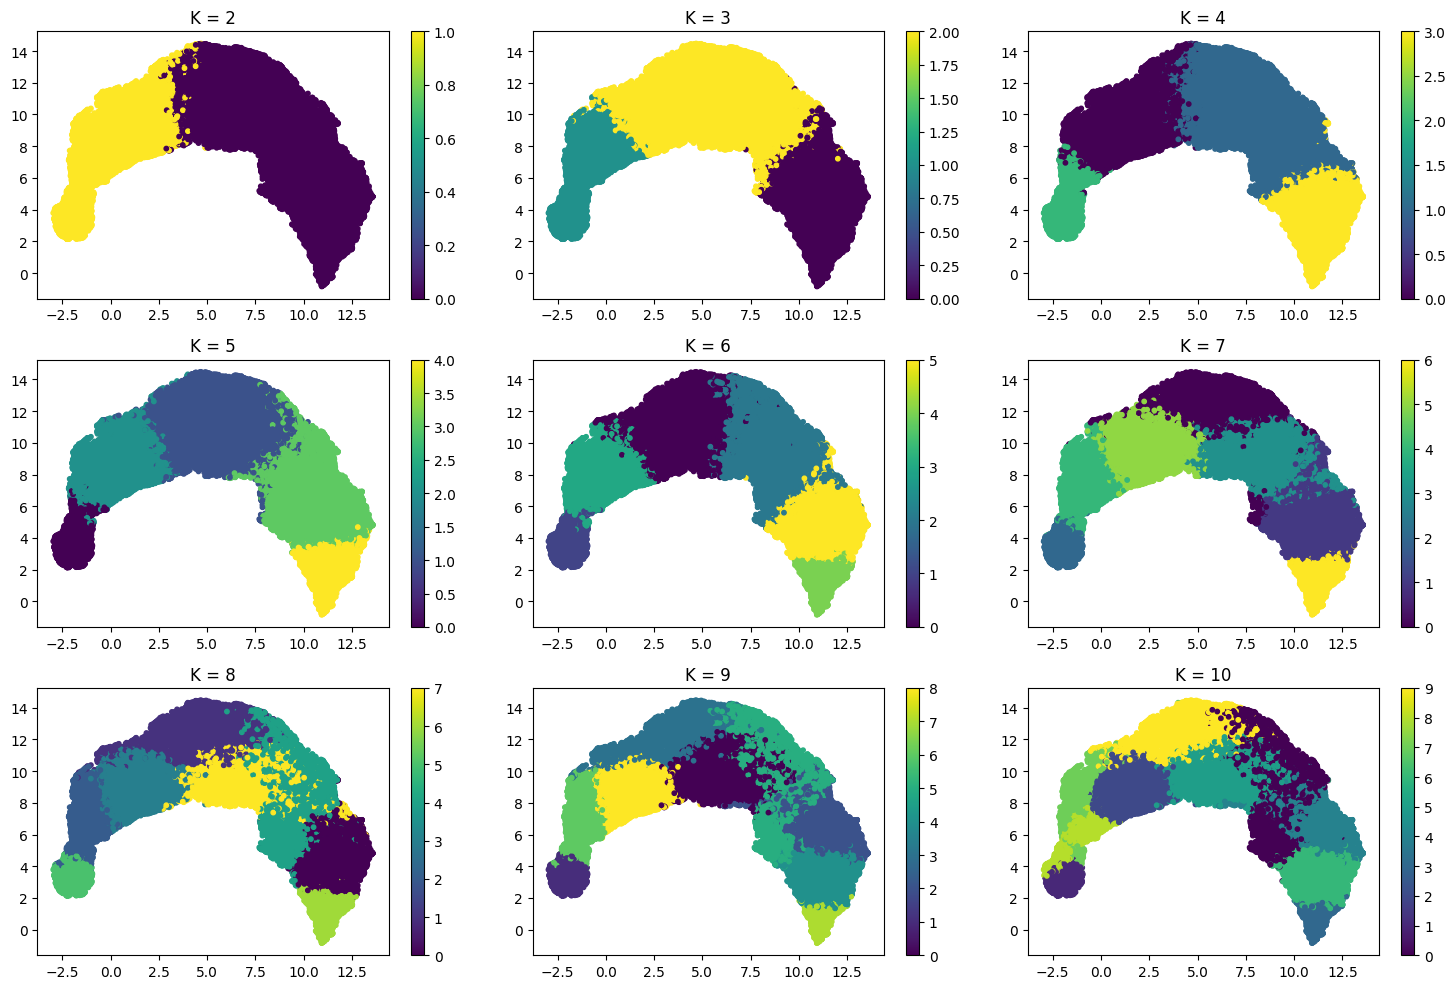

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assuming df is your DataFrame
# Sélectionner les caractéristiques pour l'analyse K-means
features = df[['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']]

# Appliquer K-means pour différentes valeurs de K
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster_k{}'.format(k)] = kmeans.fit_predict(features)

# Import UMAP from umap-learn
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

# Visualiser les clusters pour chaque valeur de K avec UMAP
plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values, 1):
    plt.subplot(3, 3, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=df['cluster_k{}'.format(k)], cmap='viridis', s=10)
    plt.title('K = {}'.format(k))
    plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# Importation des bibliothèques nécessaires
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonction pour calculer l'Overlap
def overlap(clusters, labels):
    # Calcul de la matrice de contingence entre les clusters et les vraies étiquettes
    contingency_mat = contingency_matrix(labels, clusters)
    # Calcul de l'Overlap en prenant la somme des valeurs maximales par ligne dans la matrice de contingence
    overlap_value = np.sum(np.max(contingency_mat, axis=1)) / len(labels)
    return overlap_value


k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kmeans_results = {}

# Exécution de l'algorithme K-means pour chaque valeur de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df)
    kmeans_results[k] = clusters

# Calcul du score silhouette pour chaque valeur de K
silhouette_scores = {k: silhouette_score(df, clusters) for k, clusters in kmeans_results.items()}

# Création d'un tableau de résultats avec les valeurs de K, l'Overlap et le score Silhouette
results_table = pd.DataFrame({
    'K': list(kmeans_results.keys()),
    'Overlap': [overlap(clusters, df['sentiment'].values) for clusters in kmeans_results.values()],  #
    'Silhouette Score': list(silhouette_scores.values())
})

# Affichage des résultats numériques pour chaque valeur de K
print("Résultats numériques pour chaque valeur de K:")
print(results_table)

clusters_k3 = kmeans_results[3]
true_labels = df['sentiment'].values

# Calcul des métriques de classification (Precision, Recall, F1-score) pour K=3
precision = precision_score(true_labels, clusters_k3, average='weighted')
recall = recall_score(true_labels, clusters_k3, average='weighted')
f1 = f1_score(true_labels, clusters_k3, average='weighted')

# Affichage des résultats d'évaluation pour K=3
print(f"\nÉvaluation pour K=3:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Résultats numériques pour chaque valeur de K:
    K   Overlap  Silhouette Score
0   2  0.554733          0.607839
1   3  0.383700          0.567802
2   4  0.299533          0.553112
3   5  0.252267          0.542692
4   6  0.208767          0.541577
5   7  0.186300          0.538202
6   8  0.159267          0.535840
7   9  0.141000          0.529897
8  10  0.132567          0.531058

Évaluation pour K=3:
Precision: 0.2256, Recall: 0.2523, F1-score: 0.2382


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


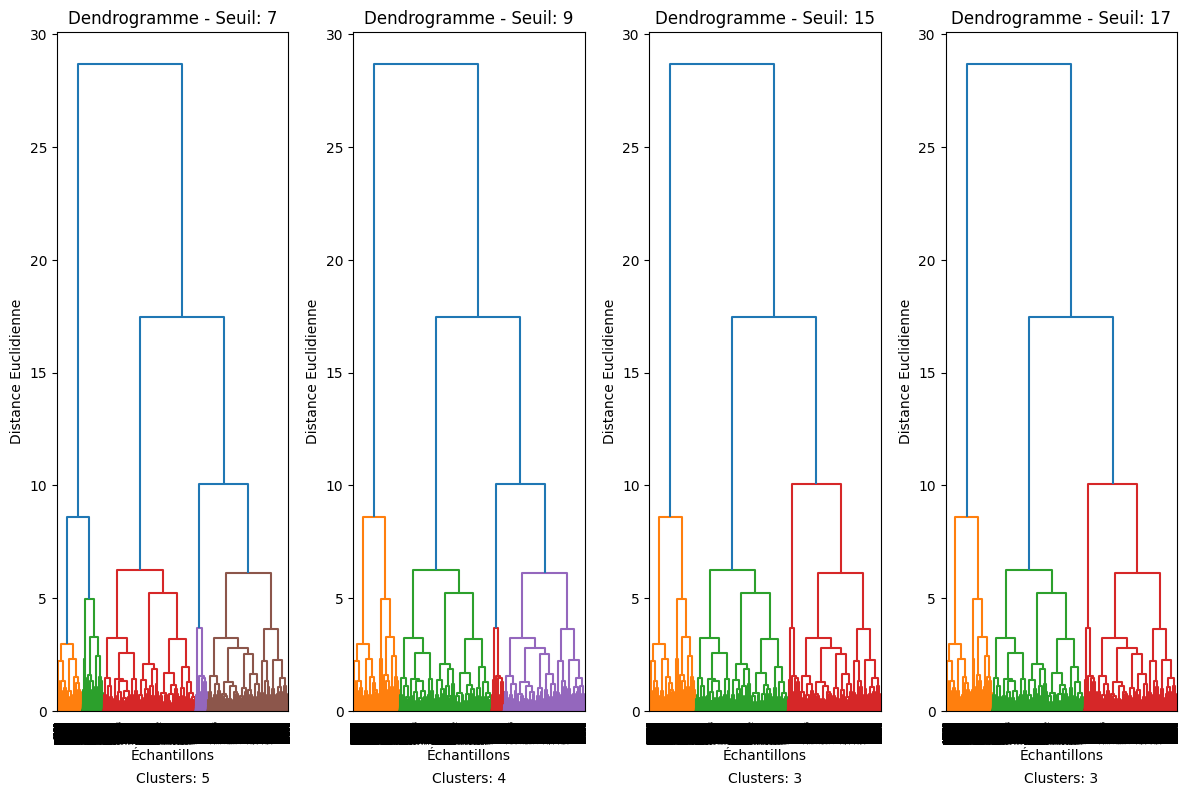

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Sélectionner les colonnes pertinentes pour le clustering
selected_columns = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
X = df[selected_columns].values

# Fonction pour afficher les dendrogrammes avec le nombre de clusters pour des seuils spécifiques
def plot_dendrogram(X):
    thresholds = [7, 9, 15, 17]  # Seuils spécifiques à tester
    plt.figure(figsize=(12, 8))
    for i, threshold in enumerate(thresholds):
        plt.subplot(1, len(thresholds), i+1)
        linked = linkage(X, method='ward')  # Utilisation de 'ward' pour la liaison
        dendrogram(linked, color_threshold=threshold)
        plt.title(f'Dendrogramme - Seuil: {threshold}')
        plt.xlabel('Échantillons')
        plt.ylabel('Distance Euclidienne')

        # Calcul du nombre de clusters pour chaque seuil
        clusters = fcluster(linked, t=threshold, criterion='distance')
        unique_clusters = np.unique(clusters)
        plt.text(0.5, -0.1, f'Clusters: {len(unique_clusters)}', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les dendrogrammes avec le nombre de clusters pour les seuils spécifiques
plot_dendrogram(X)
